##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum data

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/quantum/tutorials/quantum_data"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/quantum/blob/master/docs/tutorials/quantum_data.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/quantum_data.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/quantum/docs/tutorials/quantum_data.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Building off of the comparisons made in the [MNIST](https://www.tensorflow.org/quantum/tutorials/mnist) tutorial, this tutorial explores the recent work of [Huang et al.](https://arxiv.org/abs/2011.01938) that shows how different datasets affect performance comparisons. In the work, the authors seek to understand how and when classical machine learning models can learn as well as (or better than) quantum models. The work also showcases an empirical performance separation between classical and quantum machine learning model via a carefully crafted dataset. You will:

1.   Prepare a reduced dimension Fashion-MNIST dataset.
2.   Use quantum circuits to re-label the dataset and compute Projected Quantum Kernel features (PQK).
3.   Train a classical neural network on the re-labeled dataset and compare the performance with a model that has access to the PQK features.

## Setup

In [ ]:
!pip install tensorflow==2.15.0 tensorflow-quantum==0.7.3

In [ ]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

In [ ]:
import cirq
import sympy
import numpy as np
import tensorflow as tf
import tensorflow_quantum as tfq

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
np.random.seed(1234)

## 1. Data preparation

You will begin by preparing the fashion-MNIST dataset for running on a quantum computer.

### 1.1 Download fashion-MNIST

The first step is to get the traditional fashion-mnist dataset. This can be done using the `tf.keras.datasets` module.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Filter the dataset to keep just the T-shirts/tops and dresses, remove the other classes. At the same time convert the label, `y`, to boolean: True for 0 and False for 3.

In [ ]:
def filter_03(x, y):
    keep = (y == 0) | (y == 3)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [ ]:
x_train, y_train = filter_03(x_train, y_train)
x_test, y_test = filter_03(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12000
Number of filtered test examples: 2000


True


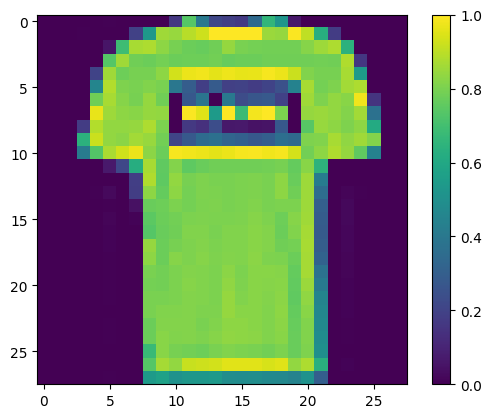

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :])
plt.colorbar()

### 1.2 Downscale the images

Just like the MNIST example, you will need to downscale these images in order to be within the boundaries for current quantum computers. This time however you will use a PCA transformation to reduce the dimensions instead of a `tf.image.resize` operation.

In [ ]:
def truncate_x(x_train, x_test, n_components=10):
  """Perform PCA on image dataset keeping the top `n_components` components."""
  n_points_train = tf.gather(tf.shape(x_train), 0)
  n_points_test = tf.gather(tf.shape(x_test), 0)

  # Flatten to 1D
  x_train = tf.reshape(x_train, [n_points_train, -1])
  x_test = tf.reshape(x_test, [n_points_test, -1])

  # Normalize.
  feature_mean = tf.reduce_mean(x_train, axis=0)
  x_train_normalized = x_train - feature_mean
  x_test_normalized = x_test - feature_mean

  # Truncate.
  e_values, e_vectors = tf.linalg.eigh(
      tf.einsum('ji,jk->ik', x_train_normalized, x_train_normalized))
  return tf.einsum('ij,jk->ik', x_train_normalized, e_vectors[:,-n_components:]), \
    tf.einsum('ij,jk->ik', x_test_normalized, e_vectors[:, -n_components:])

In [ ]:
DATASET_DIM = 10
x_train, x_test = truncate_x(x_train, x_test, n_components=DATASET_DIM)
print(f'New datapoint dimension:', len(x_train[0]))

New datapoint dimension: 10


The last step is to reduce the size of the dataset to just 1000 training datapoints and 200 testing datapoints.

In [ ]:
N_TRAIN = 1000
N_TEST = 200
x_train, x_test = x_train[:N_TRAIN], x_test[:N_TEST]
y_train, y_test = y_train[:N_TRAIN], y_test[:N_TEST]

In [ ]:
print("New number of training examples:", len(x_train))
print("New number of test examples:", len(x_test))

New number of training examples: 1000
New number of test examples: 200


## 2. Relabeling and computing PQK features

You will now prepare a "stilted" quantum dataset by incorporating quantum components and re-labeling the truncated fashion-MNIST dataset you've created above. In order to get the most seperation between quantum and classical methods, you will first prepare the PQK features and then relabel outputs based on their values.

### 2.1 Quantum encoding and PQK features
You will create a new set of features, based on `x_train`, `y_train`, `x_test` and `y_test` that is defined to be the 1-RDM on all qubits of:

$V(x_{\text{train}} / n_{\text{trotter}}) ^ {n_{\text{trotter}}} U_{\text{1qb}} | 0 \rangle$

Where $U_\text{1qb}$ is a wall of single qubit rotations and $V(\hat{\theta}) = e^{-i\sum_i \hat{\theta_i} (X_i X_{i+1} + Y_i Y_{i+1} + Z_i Z_{i+1})}$

First, you can generate the wall of single qubit rotations:

In [ ]:
def single_qubit_wall(qubits, rotations):
  """Prepare a single qubit X,Y,Z rotation wall on `qubits`."""
  wall_circuit = cirq.Circuit()
  for i, qubit in enumerate(qubits):
    for j, gate in enumerate([cirq.X, cirq.Y, cirq.Z]):
      wall_circuit.append(gate(qubit) ** rotations[i][j])

  return wall_circuit

You can quickly verify this works by looking at the circuit:

In [ ]:
SVGCircuit(single_qubit_wall(
    cirq.GridQubit.rect(1,4), np.random.uniform(size=(4, 3))))

Next you can prepare $V(\hat{\theta})$ with the help of `tfq.util.exponential` which can exponentiate any commuting `cirq.PauliSum` objects:

In [ ]:
def v_theta(qubits):
  """Prepares a circuit that generates V(\theta)."""
  ref_paulis = [
      cirq.X(q0) * cirq.X(q1) + \
      cirq.Y(q0) * cirq.Y(q1) + \
      cirq.Z(q0) * cirq.Z(q1) for q0, q1 in zip(qubits, qubits[1:])
  ]
  exp_symbols = list(sympy.symbols('ref_0:'+str(len(ref_paulis))))
  return tfq.util.exponential(ref_paulis, exp_symbols), exp_symbols

This circuit might be a little bit harder to verify by looking at, but you can still examine a two qubit case to see what is happening:

In [ ]:
test_circuit, test_symbols = v_theta(cirq.GridQubit.rect(1, 2))
print(f'Symbols found in circuit:{test_symbols}')
SVGCircuit(test_circuit)

Now you have all the building blocks you need to put your full encoding circuits together:

In [ ]:
def prepare_pqk_circuits(qubits, classical_source, n_trotter=10):
  """Prepare the pqk feature circuits around a dataset."""
  n_qubits = len(qubits)
  n_points = len(classical_source)

  # Prepare random single qubit rotation wall.
  random_rots = np.random.uniform(-2, 2, size=(n_qubits, 3))
  initial_U = single_qubit_wall(qubits, random_rots)

  # Prepare parametrized V
  V_circuit, symbols = v_theta(qubits)
  exp_circuit = cirq.Circuit(V_circuit for t in range(n_trotter))

  # Convert to `tf.Tensor`
  initial_U_tensor = tfq.convert_to_tensor([initial_U])
  initial_U_splat = tf.tile(initial_U_tensor, [n_points])

  full_circuits = tfq.layers.AddCircuit()(
      initial_U_splat, append=exp_circuit)
  # Replace placeholders in circuits with values from `classical_source`.
  return tfq.resolve_parameters(
      full_circuits, tf.convert_to_tensor([str(x) for x in symbols]),
      tf.convert_to_tensor(classical_source*(n_qubits/3)/n_trotter))

Choose some qubits and prepare the data encoding circuits:

In [ ]:
qubits = cirq.GridQubit.rect(1, DATASET_DIM + 1)
q_x_train_circuits = prepare_pqk_circuits(qubits, x_train)
q_x_test_circuits = prepare_pqk_circuits(qubits, x_test)

Next, compute the PQK features based on the 1-RDM of the dataset circuits above and store the results in `rdm`, a `tf.Tensor` with shape `[n_points, n_qubits, 3]`. The entries in `rdm[i][j][k]` = $\langle \psi_i | OP^k_j | \psi_i \rangle$ where `i` indexes over datapoints, `j` indexes over qubits and `k` indexes over $\lbrace \hat{X}, \hat{Y}, \hat{Z} \rbrace$ .

In [ ]:
def get_pqk_features(qubits, data_batch):
  """Get PQK features based on above construction."""
  ops = [[cirq.X(q), cirq.Y(q), cirq.Z(q)] for q in qubits]
  ops_tensor = tf.expand_dims(tf.reshape(tfq.convert_to_tensor(ops), -1), 0)
  batch_dim = tf.gather(tf.shape(data_batch), 0)
  ops_splat = tf.tile(ops_tensor, [batch_dim, 1])
  exp_vals = tfq.layers.Expectation()(data_batch, operators=ops_splat)
  rdm = tf.reshape(exp_vals, [batch_dim, len(qubits), -1])
  return rdm

In [ ]:
x_train_pqk = get_pqk_features(qubits, q_x_train_circuits)
x_test_pqk = get_pqk_features(qubits, q_x_test_circuits)
print('New PQK training dataset has shape:', x_train_pqk.shape)
print('New PQK testing dataset has shape:', x_test_pqk.shape)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


New PQK training dataset has shape: (1000, 11, 3)
New PQK testing dataset has shape: (200, 11, 3)


### 2.2 Re-labeling based on PQK features
Now that you have these quantum generated features in `x_train_pqk` and `x_test_pqk`, it is time to re-label the dataset. To achieve maximum seperation between quantum and classical performance you can re-label the dataset based on the spectrum information found in `x_train_pqk` and `x_test_pqk`.

Note: This preparation of your dataset to explicitly maximize the seperation in performance between the classical and quantum models might feel like cheating, but it provides a **very** important proof of existance for datasets that are hard for classical computers and easy for quantum computers to model. There would be no point in searching for quantum advantage in QML if you couldn't first create something like this to demonstrate advantage.

In [ ]:
def compute_kernel_matrix(vecs, gamma):
  """Computes d[i][j] = e^ -gamma * (vecs[i] - vecs[j]) ** 2 """
  scaled_gamma = gamma / (
      tf.cast(tf.gather(tf.shape(vecs), 1), tf.float32) * tf.math.reduce_std(vecs))
  return scaled_gamma * tf.einsum('ijk->ij',(vecs[:,None,:] - vecs) ** 2)

def get_spectrum(datapoints, gamma=1.0):
  """Compute the eigenvalues and eigenvectors of the kernel of datapoints."""
  KC_qs = compute_kernel_matrix(datapoints, gamma)
  S, V = tf.linalg.eigh(KC_qs)
  S = tf.math.abs(S)
  return S, V

In [ ]:
S_pqk, V_pqk = get_spectrum(
    tf.reshape(x_train_pqk, [-1, len(qubits) * 3]))

S_original, V_original = get_spectrum(
    tf.cast(x_train, tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix:', V_pqk)
print('Eigenvectors of original kernel matrix:', V_original)

Eigenvectors of pqk kernel matrix: tf.Tensor(
[[-0.02572668 -0.02500617 -0.00210256 ...  0.01292474 -0.00216366
   0.03198409]
 [-0.04505223 -0.00725259 -0.01396801 ... -0.00145716 -0.7412964
   0.03257377]
 [ 0.00566714  0.02528062 -0.00147861 ... -0.03087673 -0.00935522
   0.03051045]
 ...
 [-0.00952418 -0.01820112 -0.0299136  ... -0.00394092 -0.01149889
   0.0245917 ]
 [ 0.03070638 -0.03498115 -0.02656119 ...  0.0215356   0.01124762
   0.02580499]
 [ 0.00698054  0.02246808 -0.00997438 ... -0.01162745 -0.0414562
   0.0266857 ]], shape=(1000, 1000), dtype=float32)
Eigenvectors of original kernel matrix: tf.Tensor(
[[ 4.2462684e-02  3.1354256e-02  1.2604258e-02 ... -2.0111818e-02
   3.0930713e-04  3.5385568e-02]
 [-4.3868035e-02  1.0300528e-02  1.4831377e-02 ...  5.4228324e-03
   6.7345721e-01  3.1489469e-02]
 [-1.8083273e-02  1.5215975e-02  3.9878976e-02 ... -3.9398521e-03
  -5.4628002e-03  2.4036596e-02]
 ...
 [ 6.6030736e-04 -3.2971684e-02  3.1675640e-02 ...  3.9464641e-02
  -1.8377

In [ ]:
S_pqk_test, V_pqk_test = get_spectrum(
    tf.reshape(x_test_pqk, [-1, len(qubits) * 3]))

S_test_original, V_test_original = get_spectrum(
    tf.cast(x_test, tf.float32), gamma=0.005)

print('Eigenvectors of pqk kernel matrix for test:', V_pqk_test)
print('Eigenvectors of original kernel matrix for test:', V_test_original)

Eigenvectors of pqk kernel matrix for test: tf.Tensor(
[[ 0.02638157  0.02806157  0.03566442 ...  0.04386202 -0.0405141
   0.0662972 ]
 [ 0.05066229  0.01891651  0.06229709 ...  0.00191754  0.6073843
   0.07107678]
 [-0.00779327 -0.09399084 -0.06509633 ...  0.06940294 -0.00730488
   0.0816892 ]
 ...
 [ 0.02878537 -0.06277579 -0.0869303  ...  0.06611525  0.04124057
   0.08266883]
 [-0.08475214  0.01517385 -0.0412915  ... -0.04286676  0.00467837
   0.07634711]
 [ 0.03031691 -0.04953269  0.09389514 ... -0.00080099  0.04431828
   0.06373685]], shape=(200, 200), dtype=float32)
Eigenvectors of original kernel matrix for test: tf.Tensor(
[[-0.06053653 -0.10981707 -0.06392459 ...  0.09634899 -0.0199185
   0.0762083 ]
 [ 0.08907834  0.03093441  0.05701356 ... -0.02077192  0.67301965
   0.06606765]
 [ 0.07030783 -0.0973983   0.03607463 ...  0.01863695 -0.01661182
   0.07912693]
 ...
 [-0.07468248 -0.04320016  0.03100761 ...  0.01004651 -0.03957008
   0.05961308]
 [ 0.00730421 -0.12527922  0.0171

Now you have everything you need to re-label the dataset! Now you can consult with the flowchart to better understand how to maximize performance seperation when re-labeling the dataset:

<img src="https://github.com/tensorflow/quantum/blob/master/docs/tutorials/images/quantum_data_1.png?raw=1">

In order to maximize the seperation between quantum and classical models, you will attempt to maximize the geometric difference between the original dataset and the PQK features kernel matrices $g(K_1 || K_2) = \sqrt{ || \sqrt{K_2} K_1^{-1} \sqrt{K_2} || _\infty}$ using `S_pqk, V_pqk` and `S_original, V_original`. A large value of $g$ ensures that you initially move to the right in the flowchart down towards a prediction advantage in the quantum case.

Note: Computing quantities for $s$ and $d$ are also very useful when looking to better understand performance seperations. In this case ensuring a large $g$ value is enough to see performance seperation.

In [ ]:
def get_stilted_dataset(S, V, S_2, V_2, lambdav=1.1):
  """Prepare new labels that maximize geometric distance between kernels."""
  S_diag = tf.linalg.diag(S ** 0.5)
  S_2_diag = tf.linalg.diag(S_2 / (S_2 + lambdav) ** 2)
  scaling = S_diag @ tf.transpose(V) @ \
            V_2 @ S_2_diag @ tf.transpose(V_2) @ \
            V @ S_diag

  # Generate new lables using the largest eigenvector.
  _, vecs = tf.linalg.eig(scaling)
  new_labels = tf.math.real(
      tf.einsum('ij,j->i', tf.cast(V @ S_diag, tf.complex64), vecs[-1])).numpy()
  # Create new labels and add some small amount of noise.
  final_y = new_labels > np.median(new_labels)
  noisy_y = (final_y ^ (np.random.uniform(size=final_y.shape) > 0.95))
  return noisy_y

In [ ]:
y_train_new = get_stilted_dataset(S_pqk, V_pqk, S_original, V_original)
y_test_new = get_stilted_dataset(S_pqk_test, V_pqk_test, S_test_original, V_test_original)

## 3. Comparing models
Now that you have prepared your dataset it is time to compare model performance. You will create two small feedforward neural networks and compare performance when they are given access to the PQK features found in `x_train_pqk`.

### 3.1 Create PQK enhanced model
Using standard `tf.keras` library features you can now create and a train a model on the `x_train_pqk` and `y_train_new` datapoints:

In [ ]:
#docs_infra: no_execute
def create_pqk_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[len(qubits) * 3,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

pqk_model = create_pqk_model()
pqk_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              metrics=['accuracy'])

pqk_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                1088      
                                                                 
 dense_10 (Dense)            (None, 16)                528       
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 1633 (6.38 KB)
Trainable params: 1633 (6.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#docs_infra: no_execute
pqk_history = pqk_model.fit(tf.reshape(x_train_pqk, [N_TRAIN, -1]),
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(tf.reshape(x_test_pqk, [N_TEST, -1]), y_test_new))

### 3.2 Create a classical model
Similar to the code above you can now also create a classical model that doesn't have access to the PQK features in your stilted dataset. This model can be trained using `x_train` and `y_label_new`.

In [ ]:
#docs_infra: no_execute
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32, activation='sigmoid', input_shape=[DATASET_DIM,]))
    model.add(tf.keras.layers.Dense(16, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(1))
    return model

model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.03),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 32)                352       
                                                                 
 dense_13 (Dense)            (None, 16)                528       
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 897 (3.50 KB)
Trainable params: 897 (3.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#docs_infra: no_execute
classical_history = model.fit(x_train,
          y_train_new,
          batch_size=32,
          epochs=1000,
          verbose=0,
          validation_data=(x_test, y_test_new))

### 3.3 Compare performance
Now that you have trained the two models you can quickly plot the performance gaps in the validation data between the two. Typically both models will achieve > 0.9 accuaracy on the training data. However on the validation data it becomes clear that only the information found in the PQK features is enough to make the model generalize well to unseen instances.

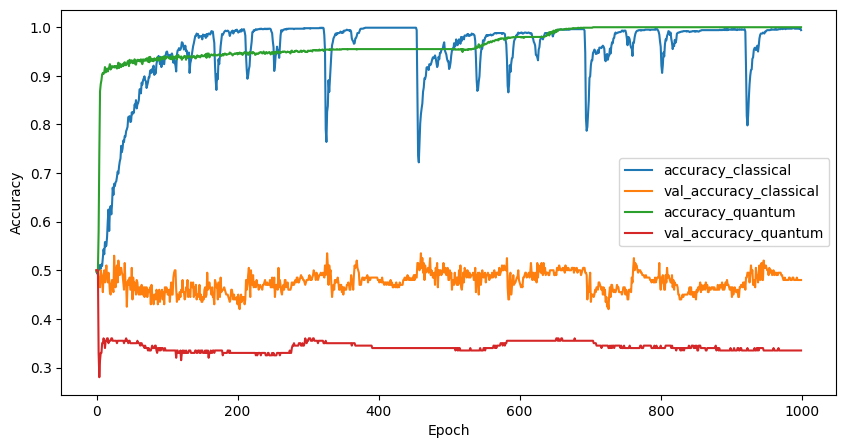

In [ ]:
#docs_infra: no_execute
plt.figure(figsize=(10,5))
plt.plot(classical_history.history['accuracy'], label='accuracy_classical')
plt.plot(classical_history.history['val_accuracy'], label='val_accuracy_classical')
plt.plot(pqk_history.history['accuracy'], label='accuracy_quantum')
plt.plot(pqk_history.history['val_accuracy'], label='val_accuracy_quantum')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Success: You have engineered a stilted quantum dataset that can intentionally defeat classical models in a fair (but contrived) setting. Try comparing results using other types of classical models. The next step is to try and see if you can find new and interesting datasets that can defeat classical models without needing to engineer them yourself!

## 4. Important conclusions

There are several important conclusions you can draw from this and the [MNIST](https://www.tensorflow.org/quantum/tutorials/mnist) experiments:

1. It's very unlikely that the quantum models of today will beat classical model performance on classical data. Especially on today's classical datasets that can have upwards of a million datapoints.

2. Just because the data might come from a hard to classically simulate quantum circuit, doesn't necessarily make the data hard to learn for a classical model.

3. Datasets (ultimately quantum in nature) that are easy for quantum models to learn and hard for classical models to learn do exist, regardless of model architecture or training algorithms used.